<a href="https://colab.research.google.com/github/owoMarciN/Python/blob/main/Intro-AI/AI_Parkinson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install torchvision
!pip install --upgrade ucimlrepo
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.7 MB/s eta 0:00:00


In [2]:
from ucimlrepo import fetch_ucirepo, list_available_datasets

# check which datasets can be imported
#list_available_datasets()

# import dataset
park = fetch_ucirepo(id=174)

# access data
X = park.data.features
y = park.data.targets
# train model e.g. sklearn.linear_model.LinearRegression().fit(X, y)

# access metadata
# print(park.metadata.uci_id)
# print(park.metadata.num_instances)
# print(park.metadata.additional_info.summary)

# access variable info in tabular format
# print(park.variables)

In [3]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
# SciKit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
# Ploting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
# Checking the data

# print(X.describe())
# print(y)

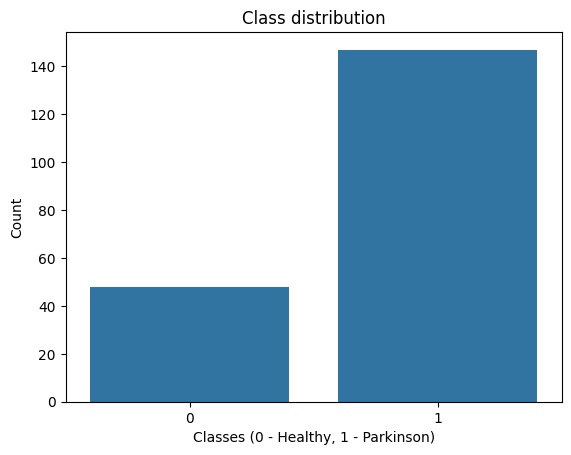

In [7]:
# Class distribution plot

sns.countplot(x=y['status'])
plt.title("Class distribution")
plt.xlabel("Classes (0 - Healthy, 1 - Parkinson)")
plt.ylabel("Count")
plt.show()

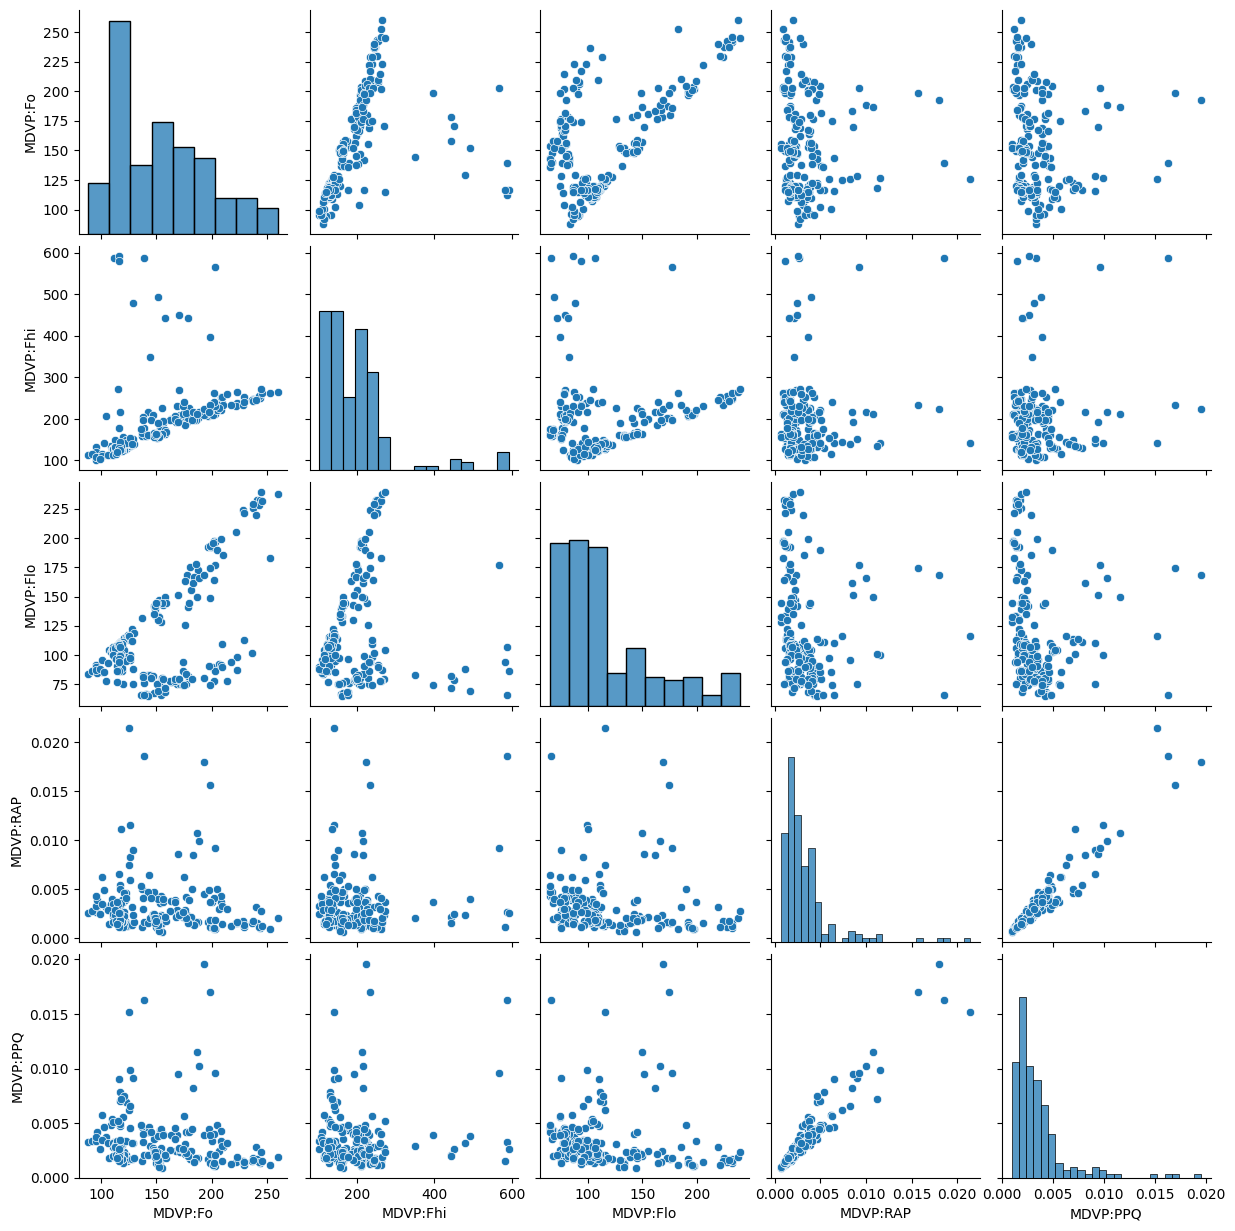

In [8]:
pp_data = X[['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:RAP', 'MDVP:PPQ']]

sns.pairplot(pp_data)
plt.show()

In [9]:
import time

class MLP(nn.Module):
    def __init__(self, in_dim=30, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def get_optimizer(name, params, lr, momentum=0.9):
    name = name.lower()
    if name == "sgd":
        return optim.SGD(params, lr=lr)
    if name == "momentum":
        return optim.SGD(params, lr=lr, momentum=momentum)
    if name == "adam":
        return optim.Adam(params, lr=lr)
    if name == "rmsprop":
        return optim.RMSprop(params, lr=lr, momentum=momentum)
    raise ValueError("Unknown optimizer")

In [10]:
def train_and_eval(opt_name, lr, epochs, momentum, Xtr, Xte, ytr, yte, in_dim=30):
    start_time = time.time()
    model = MLP(in_dim=in_dim)
    optimizer = get_optimizer(opt_name, model.parameters(), lr, momentum)
    criterion = nn.BCELoss()
    losses = []

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = criterion(outputs, ytr)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return losses, {
            "acc": accuracy_score(yte, y_pred),
            "prec": precision_score(yte, y_pred),
            "rec": recall_score(yte, y_pred),
            "f1": f1_score(yte, y_pred),
            "auc": roc_auc_score(yte, y_prob)
    }, elapsed_time

In [11]:
X = StandardScaler().fit_transform(X).astype('float32')
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

Xtr, Xte = map(torch.tensor, (Xtr, Xte))
ytr, yte = map (lambda v : torch.tensor(v.values).float(), (ytr, yte))

In [12]:
losses, metrics, elapsed_time = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
print(f"Baseline metrics (opt_name=Adam)\n {metrics}")
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Baseline metrics (opt_name=Adam)
 {'acc': 0.8974358974358975, 'prec': 0.9310344827586207, 'rec': 0.9310344827586207, 'f1': 0.9310344827586207, 'auc': np.float64(0.9586206896551724)}
Elapsed time: 18.0602 seconds


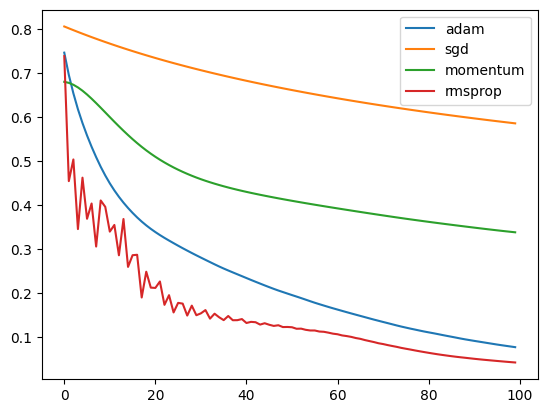

adam        acc=0.8974  f1=0.9310  time=0.8631s
sgd         acc=0.6410  f1=0.7500  time=0.1462s
momentum    acc=0.8718  f1=0.9206  time=0.3732s
rmsprop     acc=0.8718  f1=0.9180  time=0.3374s


In [13]:
# baseline MLP
opt = ["adam", "sgd", "momentum", "rmsprop"]
losses_all = []
f1_all = []
acc_all = []
epochs = []
elapsed_times = []

for opt_name in opt:
    losses, metrics, elapsed_time = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
    f1_all.append(metrics["f1"])
    acc_all.append(metrics["acc"])
    losses_all.append(losses)
    elapsed_times.append(elapsed_time)

for i, opt_name in enumerate(opt):
    plt.plot(losses_all[i], label=opt_name)
plt.legend()
plt.savefig("lossfun.png")
plt.show()

for i, opt_name in enumerate(opt):
    print(f"{opt_name:10s}  acc={acc_all[i]:.4f}  f1={f1_all[i]:.4f}  time={elapsed_times[i]:.4f}s")

In [14]:
def train_and_eval(opt_name, lr, epochs, momentum, Xtr, Xte, ytr, yte, in_dim=30):
    start_time = time.time()
    model = MLP(in_dim=in_dim)
    optimizer = get_optimizer(opt_name, model.parameters(), lr, momentum)
    criterion = nn.BCELoss()
    losses = []
    f1_scores = []

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = criterion(outputs, ytr)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        model.eval()
        with torch.no_grad():
            y_prob = model(Xte).numpy()
        y_pred = (y_prob >= 0.5).astype(int)
        f1_scores.append(f1_score(yte, y_pred))

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return losses, {
            "acc": accuracy_score(yte, y_pred),
            "prec": precision_score(yte, y_pred),
            "rec": recall_score(yte, y_pred),
            "f1": f1_score(yte, y_pred),
            "auc": roc_auc_score(yte, y_prob)
    }, elapsed_time, f1_scores

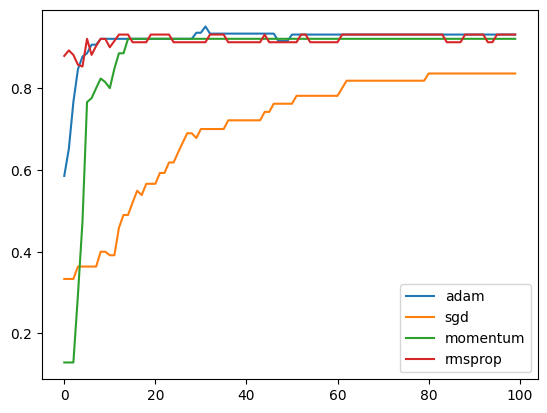

In [15]:
# baseline MLP
opt = ["adam", "sgd", "momentum", "rmsprop"]
losses_all = []
f1_all = []
acc_all = []
epochs = []
elapsed_times = []

for opt_name in opt:
    losses, metrics, elapsed_time, f1_scores = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
    f1_all.append(f1_scores)

for i, opt_name in enumerate(opt):
    plt.plot(f1_all[i], label=opt_name)
plt.legend()
plt.show()

In [16]:
from torch.optim.lr_scheduler import StepLR

def train_and_eval(opt_name, lr, epochs, momentum, Xtr, Xte, ytr, yte, in_dim=30):
    start_time = time.time()
    model = MLP(in_dim=in_dim)
    optimizer = get_optimizer(opt_name, model.parameters(), lr, momentum)
    criterion = nn.BCELoss()
    losses = []
    l_rates = []

    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = criterion(outputs, ytr)
        loss.backward()

        losses.append(loss.item())
        l_rates.append(scheduler.get_last_lr())

        optimizer.step()
        scheduler.step()

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return losses, {
            "acc": accuracy_score(yte, y_pred),
            "prec": precision_score(yte, y_pred),
            "rec": recall_score(yte, y_pred),
            "f1": f1_score(yte, y_pred),
            "auc": roc_auc_score(yte, y_prob)
    }, elapsed_time, l_rates

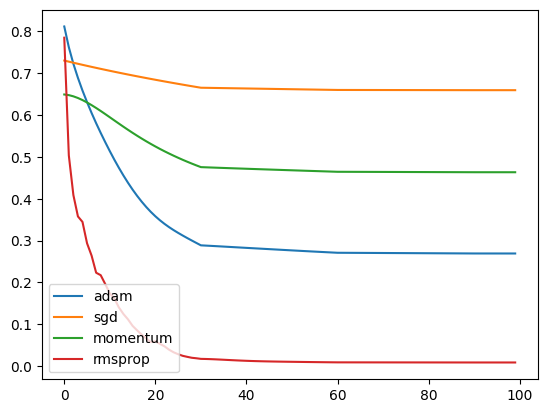

adam        acc=0.8974  f1=0.9355  time=0.2062s
sgd         acc=0.6410  f1=0.7083  time=0.1091s
momentum    acc=0.7692  f1=0.8657  time=0.1230s
rmsprop     acc=0.8974  f1=0.9310  time=0.1714s


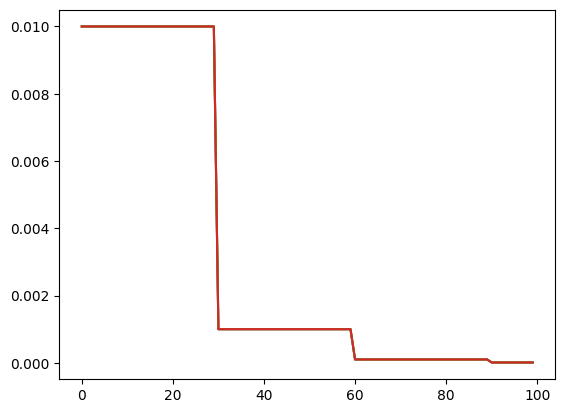

In [17]:
# baseline MLP
opt = ["adam", "sgd", "momentum", "rmsprop"]
losses_all = []
f1_all = []
acc_all = []
epochs = []
elapsed_times = []
lr_all = []

for opt_name in opt:
    losses, metrics, elapsed_time, l_rates = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
    f1_all.append(metrics["f1"])
    acc_all.append(metrics["acc"])
    losses_all.append(losses)
    lr_all.append(l_rates)
    elapsed_times.append(elapsed_time)

for i, opt_name in enumerate(opt):
    plt.plot(losses_all[i], label=opt_name)
plt.legend()
plt.show()

for i, opt_name in enumerate(opt):
    print(f"{opt_name:10s}  acc={acc_all[i]:.4f}  f1={f1_all[i]:.4f}  time={elapsed_times[i]:.4f}s")


for i, opt_name in enumerate(opt):
    plt.plot(lr_all[i])
plt.show()

In [18]:
def kmeans_features(X_train, X_test, n_clusters=8, random_state=42):
    # Ensure inputs are NumPy arrays for KMeans and subsequent NumPy operations
    if isinstance(X_train, torch.Tensor):
        X_train_np = X_train.numpy()
    else:
        X_train_np = X_train

    if isinstance(X_test, torch.Tensor):
        X_test_np = X_test.numpy()
    else:
        X_test_np = X_test

    kmeans = KMeans(n_clusters=n_clusters,
    n_init=10,
    random_state=random_state)
    kmeans.fit(X_train_np)

    def to_dist(X_arr):
        # X_arr will already be a NumPy array if the outer conversion happened
        return np.linalg.norm(
            X_arr[:, None, :] - kmeans.cluster_centers_[None, :, :],
            axis=2
            ).astype("float32")

    return to_dist(X_train_np), to_dist(X_test_np)

In [19]:
Xtr_km, Xte_km = kmeans_features(Xtr, Xte, n_clusters=8)

Xtr_km = torch.tensor(Xtr_km, dtype=torch.float32)
Xte_km = torch.tensor(Xte_km, dtype=torch.float32)

losses, metrics, elapsed_time, l_rates = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_km, Xte=Xte_km, ytr=ytr, yte=yte, in_dim=8)
metrics

{'acc': 0.8717948717948718,
 'prec': 0.8529411764705882,
 'rec': 1.0,
 'f1': 0.9206349206349206,
 'auc': np.float64(0.8517241379310345)}

In [20]:
def pca_features(X_train, X_test, var_threshold=0.95, random_state=42):
    # PCA
    pca = PCA(n_components=var_threshold, random_state=random_state)

    pca.fit(X_train)

    # Transformation train/test
    X_train_pca = pca.transform(X_train).astype("float32")
    X_test_pca = pca.transform(X_test).astype("float32")

    # Number of components
    n_components = pca.n_components_

    print(f"We used {n_components} PCA components, to get ≥{int(var_threshold*100)}% variation.")

    return X_train_pca, X_test_pca, n_components

In [21]:
Xtr_pca, Xte_pca, n_components = pca_features(Xtr, Xte, var_threshold=0.95)

Xtr_pca = torch.tensor(Xtr_pca, dtype=torch.float32)
Xte_pca = torch.tensor(Xte_pca, dtype=torch.float32)

losses, metrics, elapsed_time, l_rates = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_pca, Xte=Xte_pca, ytr=ytr, yte=yte, in_dim=n_components)
metrics

We used 8 PCA components, to get ≥95% variation.


{'acc': 0.8717948717948718,
 'prec': 0.8529411764705882,
 'rec': 1.0,
 'f1': 0.9206349206349206,
 'auc': np.float64(0.9551724137931034)}

In [22]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=30, bottleneck_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

    def encode(self, x):
        """Returns the 8-D bottleneck representation."""
        return self.encoder(x)

In [23]:
def autoencoder_features(X_train, X_test, epochs=50, lr=1e-3):
    input_dim = X_train.shape[1]
    bottleneck_dim = 8

    ae = Autoencoder(input_dim=input_dim, bottleneck_dim=bottleneck_dim)
    optimizer = optim.Adam(ae.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    Xtr_tensor = X_train.float()

    # Training loop
    for _ in range(epochs):
        optimizer.zero_grad()
        recon = ae(Xtr_tensor)
        loss = loss_fn(recon, Xtr_tensor)
        loss.backward()
        optimizer.step()

    # Extract 8-D features
    with torch.no_grad():
        Z_train = ae.encode(X_train.float())
        Z_test  = ae.encode(X_test.float())

    return Z_train, Z_test

In [25]:
Xtr_ae, Xte_ae = autoencoder_features(Xtr, Xte, epochs=100, lr=1e-3)

losses, metrics, elapsed_time, l_rates = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_ae, Xte=Xte_ae, ytr=ytr, yte=yte, in_dim=8)
metrics

{'acc': 0.8717948717948718,
 'prec': 0.8529411764705882,
 'rec': 1.0,
 'f1': 0.9206349206349206,
 'auc': np.float64(0.8172413793103448)}

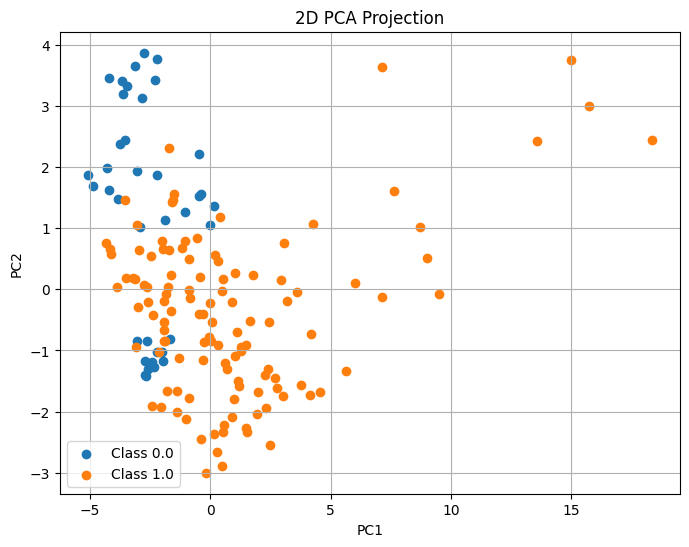

In [26]:
from sklearn.decomposition import PCA
ytr_np = ytr.numpy().ravel()

# PCA 2D
pca_2d = PCA(n_components=2)
Xtr_pca_2d = pca_2d.fit_transform(Xtr_pca)  # Xtr should be NumPy

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(ytr_np):
    plt.scatter(Xtr_pca_2d[ytr_np == label, 0], Xtr_pca_2d[ytr_np == label, 1], label=f"Class {label}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection")
plt.legend()
plt.grid(True)
plt.show()

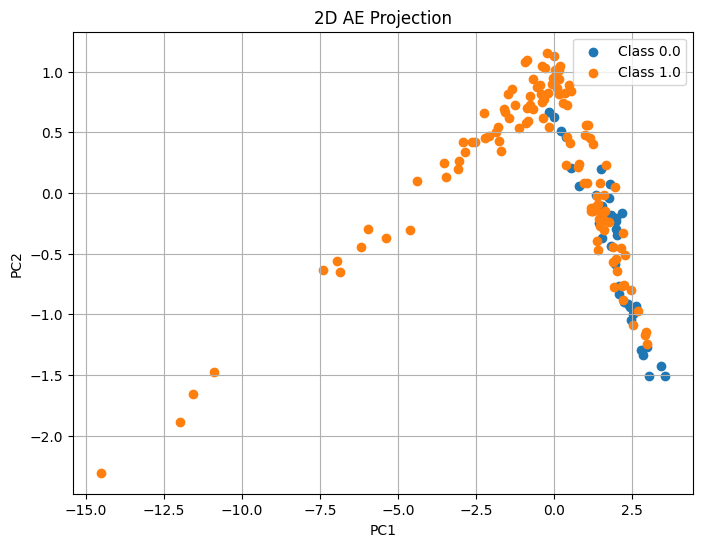

In [27]:
ytr_np = ytr.numpy().ravel()

# PCA 2D
pca_2d = PCA(n_components=2)
Xtr_ae_2d = pca_2d.fit_transform(Xtr_ae)

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(ytr_np):
    plt.scatter(Xtr_ae_2d[ytr_np == label, 0], Xtr_ae_2d[ytr_np == label, 1], label=f"Class {label}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D AE Projection")
plt.legend()
plt.grid(True)
plt.show()

## Hyper-parameters


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import itertools
import random
import optuna

from torch.utils.data import DataLoader, TensorDataset
from optuna.samplers import TPESampler, NSGAIISampler, GridSampler, RandomSampler
from optuna.pruners import HyperbandPruner

In [29]:
search_space = {
    "lr": [1e-4, 1e-3, 1e-2, 1e-1],
    "momentum": [0.7, 0.8, 0.9, 0.99],
    "hidden_size": [8, 16, 32],
    "weight_decay": [0.001, 0.01],
    "batch_size": [16, 32, 64]
}

In [61]:
class MLP(nn.Module):
    def __init__(self, in_dim=30, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def get_optimizer(name, params, lr, momentum=0.9, weight_decay=0.0):
    name = name.lower()
    if name == "sgd":
        return optim.SGD(params, lr=lr, weight_decay=weight_decay)
    if name == "momentum":
        return optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    if name == "adam":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if name == "rmsprop":
        return optim.RMSprop(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    raise ValueError(f"Unknown optimizer: {name}")

def train_and_eval_hparams(opt_name, Xtr, Xte, ytr, yte, hparams):
    start_time = time.time()
    model = MLP(in_dim=Xtr.shape[1], hidden=hparams["hidden_size"])
    optimizer = get_optimizer(opt_name, model.parameters(), lr=hparams["lr"], momentum=hparams["momentum"], weight_decay=hparams["weight_decay"])
    criterion = nn.BCELoss()
    losses = []

    train_loader = DataLoader(
        TensorDataset(Xtr, ytr),
        batch_size=hparams["batch_size"],
        shuffle=True
    )

    for epoch in range(100):
        model.train()
        batch_losses = []
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb.float())
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        losses.append(np.mean(batch_losses))

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)

    end_time = time.time()
    elapsed_time = end_time - start_time

    metrics = {
        "acc": accuracy_score(yte, y_pred),
        "prec": precision_score(yte, y_pred, zero_division=0),
        "rec": recall_score(yte, y_pred, zero_division=0),
        "f1": f1_score(yte, y_pred, zero_division=0),
        "auc": roc_auc_score(yte, y_prob)
    }

    return metrics, losses, elapsed_time

In [31]:
def objective(opt_name, Xtr, Xte, ytr, yte, trial):
    hp = {
        "lr": trial.suggest_float("lr", 1e-4, 1e-1, log=True),
        "momentum": trial.suggest_float("momentum", 0.7, 0.99),
        "hidden_size": trial.suggest_categorical("hidden_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64])
    }

    metrics, losses, elapsed_time_val = train_and_eval_hparams(opt_name, Xtr, Xte, ytr, yte, hp)
    trial.set_user_attr("losses", losses)
    trial.set_user_attr("elapsed_time", elapsed_time_val)
    trial.set_user_attr("optimizer", opt_name)
    trial.set_user_attr("metrics", metrics)
    return metrics["f1"]

In [32]:
# Optuna Grid Search
def run_optuna_grid_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=GridSampler(search_space=search_space)
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [33]:
# Optuna Random Search
def run_optuna_random_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=RandomSampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [34]:
# Bayesian Optimization — Build surrogate model of performance.
def run_bayesian_optimization(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler()
    )
    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [35]:
# Hyperband / BOHB — Adaptive resource allocation.
def run_hyperband(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        pruner=HyperbandPruner()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [36]:
# Evolutionary / Metaheuristic Search — GA, PSO, DE for AutoML.
def run_evolutionary(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=NSGAIISampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [62]:
results = {}

# As for now testing the baseline with 'Adam' optimizer
adam_opt = "adam"

# Baselines
grid_hp, grid_f1, grid_traj, grid_perf, grid_loss, grid_met = run_optuna_grid_search(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Grid"] = grid_hp
results["Grid_f1"] = grid_f1
results["Grid_traj"] = grid_traj
results["Grid_perf"] = grid_perf
results["Grid_loss"] = grid_loss
results["Grid_met"] = grid_met

rand_hp, rand_f1, rand_traj, rand_perf, rand_loss, rand_met = run_optuna_random_search(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Random"] = rand_hp
results["Random_f1"] = rand_f1
results["Random_traj"] = rand_traj
results["Random_perf"] = rand_perf
results["Random_loss"] = rand_loss
results["Random_met"] = rand_met

# Advanced methods
bo_hp, bo_f1, bo_traj, bo_perf, bo_loss, bo_met = run_bayesian_optimization(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Bayes"] = bo_hp
results["Bayes_f1"] = bo_f1
results["Bayes_traj"] = bo_traj
results["Bayes_perf"] = bo_perf
results["Bayes_loss"] = bo_loss
results["Bayes_met"] = bo_met

hb_hp, hb_f1, hb_traj, hb_perf, hb_loss, hb_met = run_hyperband(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Hyperband"] = hb_hp
results["Hyperband_f1"] = hb_f1
results["Hyperband_traj"] = hb_traj
results["Hyperband_perf"] = hb_perf
results["Hyperband_loss"] = hb_loss
results["Hyperband_met"] = hb_met

ev_hp, ev_f1, ev_traj, ev_perf, ev_loss, ev_met = run_evolutionary(
            opt_name=adam_opt,
            Xtr=Xtr,
            Xte=Xte,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
results["Evolutionary"] = ev_hp
results["Evolutionary_f1"] = ev_f1
results["Evolutionary_traj"] = ev_traj
results["Evolutionary_perf"] = ev_perf
results["Evolutionary_loss"] = ev_loss
results["Evolutionary_met"] = ev_met

[I 2025-11-30 08:29:09,691] A new study created in memory with name: no-name-1d247709-20e5-4c97-95be-b87013459820
[I 2025-11-30 08:29:11,760] Trial 0 finished with value: 0.9310344827586207 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 16, 'weight_decay': 0.01, 'batch_size': 16}. Best is trial 0 with value: 0.9310344827586207.
[I 2025-11-30 08:29:13,141] Trial 1 finished with value: 0.9666666666666667 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 32}. Best is trial 1 with value: 0.9666666666666667.
[I 2025-11-30 08:29:16,366] Trial 2 finished with value: 0.9666666666666667 and parameters: {'lr': 0.1, 'momentum': 0.9, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 16}. Best is trial 1 with value: 0.9666666666666667.
[I 2025-11-30 08:29:17,246] Trial 3 finished with value: 0.896551724137931 and parameters: {'lr': 0.01, 'momentum': 0.7, 'hidden_size': 8, 'weight_decay': 0.001, 'batch_size': 64}. Best is tria

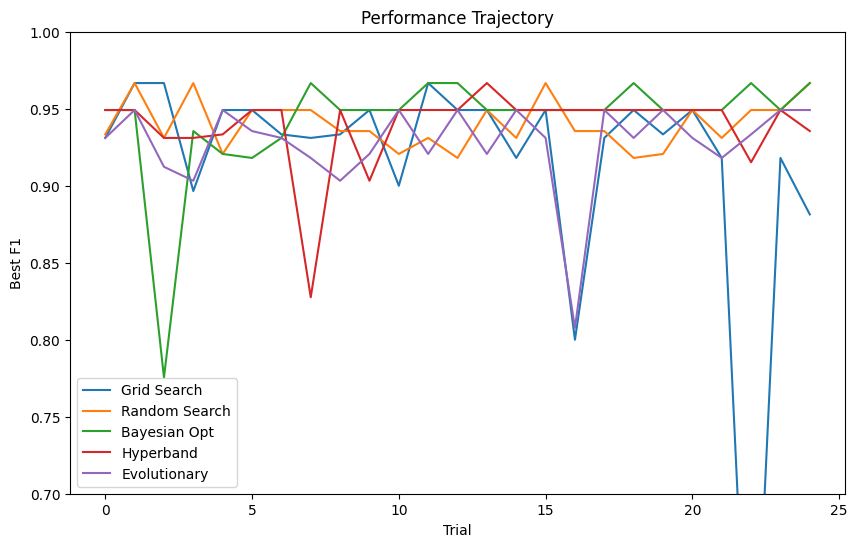

In [66]:
# ------------------------------------------------------------------------------
# Truncate trajectories and performances for consistent plotting, as Optuna
# Grid Search runs all combinations while other methods are limited by
# n_trials (defaulting to 25).
# ------------------------------------------------------------------------------

N_TRIALS = 25

plt.figure(figsize=(10, 6))
plt.plot(results["Grid_traj"][:N_TRIALS], label="Grid Search")
plt.plot(results["Random_traj"][:N_TRIALS], label="Random Search")
plt.plot(results["Bayes_traj"][:N_TRIALS], label="Bayesian Opt")
plt.plot(results["Hyperband_traj"][:N_TRIALS], label="Hyperband")
plt.plot(results["Evolutionary_traj"][:N_TRIALS], label="Evolutionary")

plt.ylim([0.7, 1.0])
plt.xlabel("Trial")
plt.ylabel("Best F1")
plt.title("Performance Trajectory")
plt.legend()
plt.show()

# ------------------------------------------------------------------------------
# Changes to the evaluation class must be made if you want the 'elapsed_time'
# trajectories.
# For now 'grid_perf' returns only the best trial performance time.
# ------------------------------------------------------------------------------

# plt.figure(figsize=(10, 6))
# plt.plot(results["Grid_perf"][:N_TRIALS], label="Grid Search")
# plt.plot(results["Random_perf"][:N_TRIALS], label="Random Search")
# plt.plot(results["Bayes_perf"][:N_TRIALS], label="Bayesian Opt")
# plt.plot(results["Hyperband_perf"][:N_TRIALS], label="Hyperband")
# plt.plot(results["Evolutionary_perf"][:N_TRIALS], label="Evolutionary")

# plt.xlabel("Trial")
# plt.ylabel("Elapsed Time (s)")
# plt.title("Elapsed Time per Trial")
# plt.legend()
# plt.show()

In [70]:
table = pd.DataFrame({
    "Method": ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"],
    "Best F1": [results["Grid_met"]["f1"], results["Random_met"]["f1"], results["Bayes_met"]["f1"], results["Hyperband_met"]["f1"], results["Evolutionary_met"]["f1"]],
    "Accuracy": [results["Grid_met"]["acc"], results["Random_met"]["acc"], results["Bayes_met"]["acc"], results["Hyperband_met"]["acc"], results["Evolutionary_met"]["acc"]],
    "Precision": [results["Grid_met"]["prec"], results["Random_met"]["prec"], results["Bayes_met"]["prec"], results["Hyperband_met"]["prec"], results["Evolutionary_met"]["prec"]],
    "Recall": [results["Grid_met"]["rec"], results["Random_met"]["rec"], results["Bayes_met"]["rec"], results["Hyperband_met"]["rec"], results["Evolutionary_met"]["rec"]],
    "AUC": [results["Grid_met"]["auc"], results["Random_met"]["auc"], results["Bayes_met"]["auc"], results["Hyperband_met"]["auc"], results["Evolutionary_met"]["auc"]],
    "Training time": [results["Grid_perf"], results["Random_perf"], results["Bayes_perf"], results["Hyperband_perf"], results["Evolutionary_perf"]],
    "Best Params": [
        results["Grid"], results["Random"], results["Bayes"], results["Hyperband"], results["Evolutionary"]
    ]

})

print(table)
table.to_latex(index=False)

         Method   Best F1  Accuracy  Precision    Recall       AUC  \
0          Grid  0.966667  0.948718   0.935484  1.000000  0.982759   
1        Random  0.966667  0.948718   0.935484  1.000000  0.975862   
2         Bayes  0.966667  0.948718   0.935484  1.000000  0.968966   
3     Hyperband  0.966667  0.948718   0.935484  1.000000  0.979310   
4  Evolutionary  0.949153  0.923077   0.933333  0.965517  0.975862   

   Training time                                        Best Params  
0       1.359054  {'lr': 0.01, 'momentum': 0.99, 'hidden_size': ...  
1       2.016286  {'lr': 0.006763665481650533, 'momentum': 0.927...  
2       1.381566  {'lr': 0.04710907935607218, 'momentum': 0.9518...  
3       1.019855  {'lr': 0.010777916821022948, 'momentum': 0.701...  
4       2.669140  {'lr': 0.029025120810176275, 'momentum': 0.976...  


"\\begin{tabular}{lrrrrrrl}\n\\toprule\nMethod & Best F1 & Accuracy & Precision & Recall & AUC & Training time & Best Params \\\\\n\\midrule\nGrid & 0.966667 & 0.948718 & 0.935484 & 1.000000 & 0.982759 & 1.359054 & {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 32} \\\\\nRandom & 0.966667 & 0.948718 & 0.935484 & 1.000000 & 0.975862 & 2.016286 & {'lr': 0.006763665481650533, 'momentum': 0.9275832673872052, 'hidden_size': 32, 'weight_decay': 0.0022720629998164424, 'batch_size': 16} \\\\\nBayes & 0.966667 & 0.948718 & 0.935484 & 1.000000 & 0.968966 & 1.381566 & {'lr': 0.04710907935607218, 'momentum': 0.9518587640935854, 'hidden_size': 32, 'weight_decay': 0.00012683064199916713, 'batch_size': 16} \\\\\nHyperband & 0.966667 & 0.948718 & 0.935484 & 1.000000 & 0.979310 & 1.019855 & {'lr': 0.010777916821022948, 'momentum': 0.7010158493747436, 'hidden_size': 32, 'weight_decay': 0.0008983493334338399, 'batch_size': 32} \\\\\nEvolutionary & 0.949153 & 0.9230

## Everything together - Optimizers $\times$ Reduction Techniques $\times$ Hyper-parameters



In [50]:
results = {}

opt = ["adam", "sgd", "momentum", "rmsprop"]

features = {
    "raw": (Xtr, Xte),
    "kmeans": kmeans_features(Xtr, Xte, n_clusters=8),
    "pca": pca_features(Xtr, Xte, var_threshold=0.95)[:2],
    "autoencoder": autoencoder_features(Xtr, Xte, epochs=100, lr=1e-2)
}

# Convert all to tensors
for key, (Xtr_feat, Xte_feat) in features.items():
    features[key] = (torch.tensor(Xtr_feat, dtype=torch.float32),
                     torch.tensor(Xte_feat, dtype=torch.float32))

for feat_name, (Xtr_feat, Xte_feat) in features.items():
    results[feat_name] = {}

    for opt_name in opt:
        results[feat_name][opt_name] = {}  # Create sub-dict for each optimizer

        # Baselines
        grid_hp, grid_f1, grid_traj, grid_perf, grid_loss, grid_met = run_optuna_grid_search(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Grid"] = grid_hp
        results[feat_name][opt_name]["Grid_f1"] = grid_f1
        results[feat_name][opt_name]["Grid_traj"] = grid_traj
        results[feat_name][opt_name]["Grid_perf"] = grid_perf
        results[feat_name][opt_name]["Grid_loss"] = grid_loss
        results[feat_name][opt_name]["Grid_met"] = grid_met

        rand_hp, rand_f1, rand_traj, rand_perf, rand_loss, rand_met = run_optuna_random_search(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Random"] = rand_hp
        results[feat_name][opt_name]["Random_f1"] = rand_f1
        results[feat_name][opt_name]["Random_traj"] = rand_traj
        results[feat_name][opt_name]["Random_perf"] = rand_perf
        results[feat_name][opt_name]["Random_loss"] = rand_loss
        results[feat_name][opt_name]["Random_met"] = rand_met

        # Advanced methods
        bo_hp, bo_f1, bo_traj, bo_perf, bo_loss, bo_met = run_bayesian_optimization(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Bayes"] = bo_hp
        results[feat_name][opt_name]["Bayes_f1"] = bo_f1
        results[feat_name][opt_name]["Bayes_traj"] = bo_traj
        results[feat_name][opt_name]["Bayes_perf"] = bo_perf
        results[feat_name][opt_name]["Bayes_loss"] = bo_loss
        results[feat_name][opt_name]["Bayes_met"] = bo_met

        hb_hp, hb_f1, hb_traj, hb_perf, hb_loss, hb_met = run_hyperband(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Hyperband"] = hb_hp
        results[feat_name][opt_name]["Hyperband_f1"] = hb_f1
        results[feat_name][opt_name]["Hyperband_traj"] = hb_traj
        results[feat_name][opt_name]["Hyperband_perf"] = hb_perf
        results[feat_name][opt_name]["Hyperband_loss"] = hb_loss
        results[feat_name][opt_name]["Hyperband_met"] = hb_met

        ev_hp, ev_f1, ev_traj, ev_perf, ev_loss, ev_met = run_evolutionary(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Evolutionary"] = ev_hp
        results[feat_name][opt_name]["Evolutionary_f1"] = ev_f1
        results[feat_name][opt_name]["Evolutionary_traj"] = ev_traj
        results[feat_name][opt_name]["Evolutionary_perf"] = ev_perf
        results[feat_name][opt_name]["Evolutionary_loss"] = ev_loss
        results[feat_name][opt_name]["Evolutionary_met"] = ev_met

/tmp/ipython-input-812956446.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features[key] = (torch.tensor(Xtr_feat, dtype=torch.float32),
/tmp/ipython-input-812956446.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(Xte_feat, dtype=torch.float32))
[I 2025-11-30 07:50:49,403] A new study created in memory with name: no-name-5ca41d0a-5caf-4d96-829f-d4f0a0e5e9bd


We used 8 PCA components, to get ≥95% variation.


[I 2025-11-30 07:50:50,793] Trial 0 finished with value: 0.9491525423728814 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 16, 'weight_decay': 0.01, 'batch_size': 16}. Best is trial 0 with value: 0.9491525423728814.
[I 2025-11-30 07:50:51,487] Trial 1 finished with value: 0.9666666666666667 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 32}. Best is trial 1 with value: 0.9666666666666667.
[I 2025-11-30 07:50:52,728] Trial 2 finished with value: 0.9491525423728814 and parameters: {'lr': 0.1, 'momentum': 0.9, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 16}. Best is trial 1 with value: 0.9666666666666667.
[I 2025-11-30 07:50:53,252] Trial 3 finished with value: 0.9491525423728814 and parameters: {'lr': 0.01, 'momentum': 0.7, 'hidden_size': 8, 'weight_decay': 0.001, 'batch_size': 64}. Best is trial 1 with value: 0.9666666666666667.
[I 2025-11-30 07:50:53,748] Trial 4 finished with value: 0.9666666666666667 a

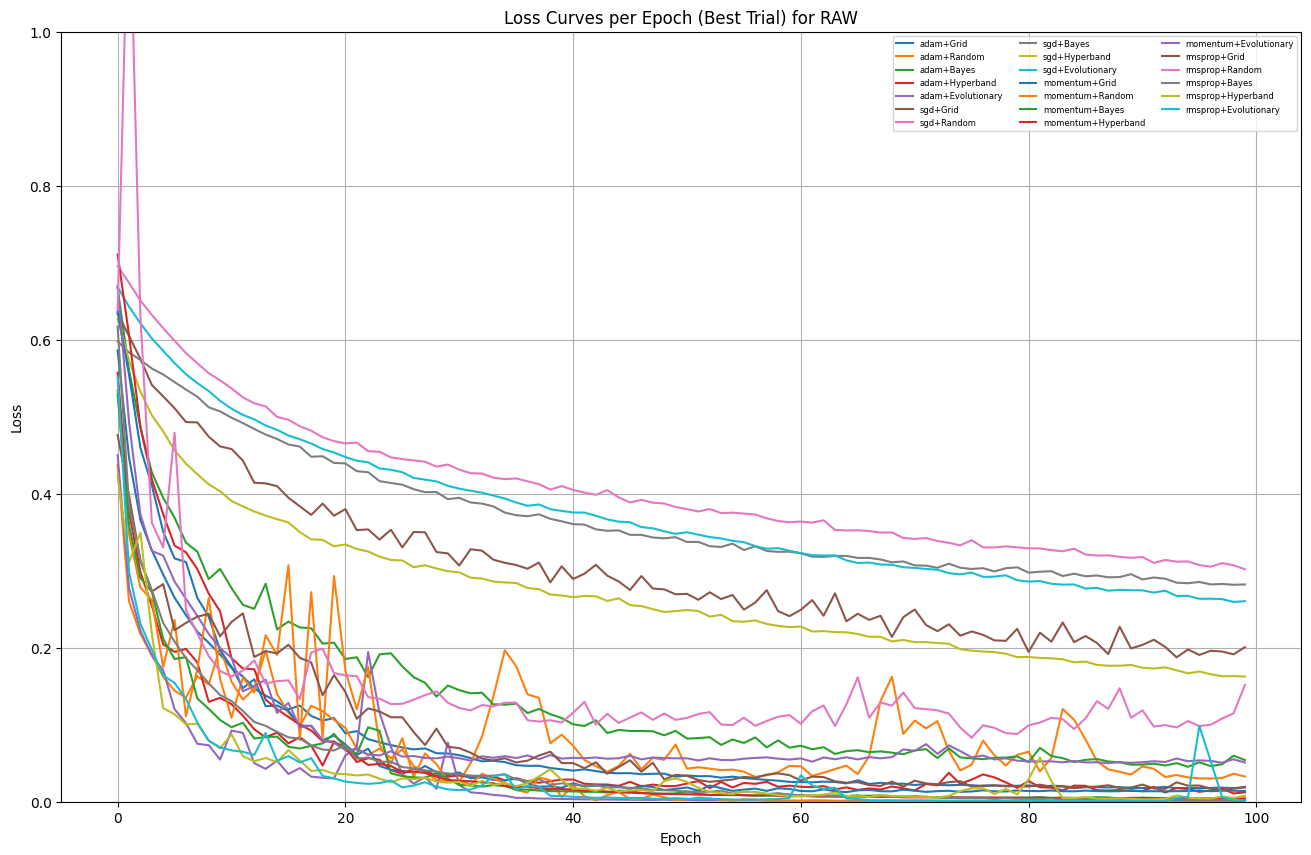

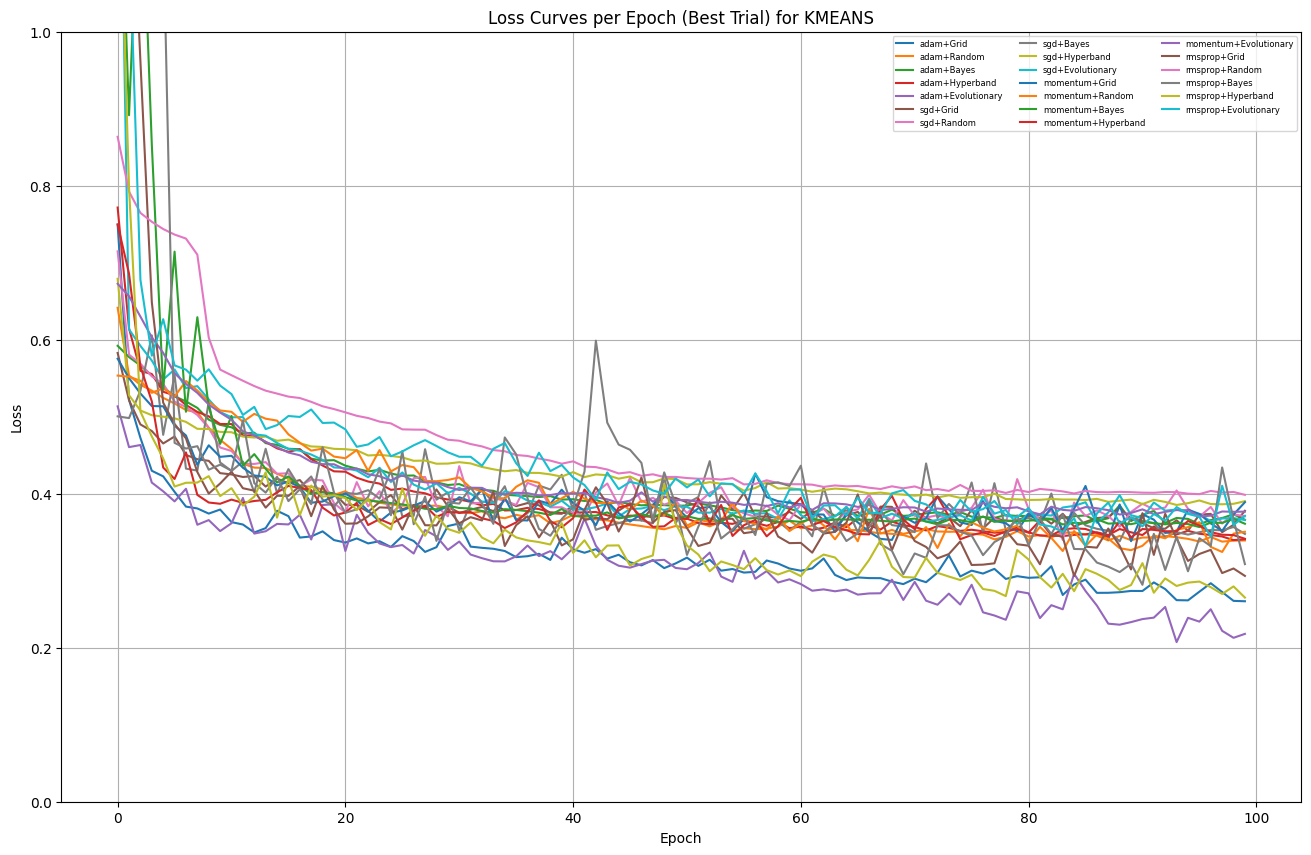

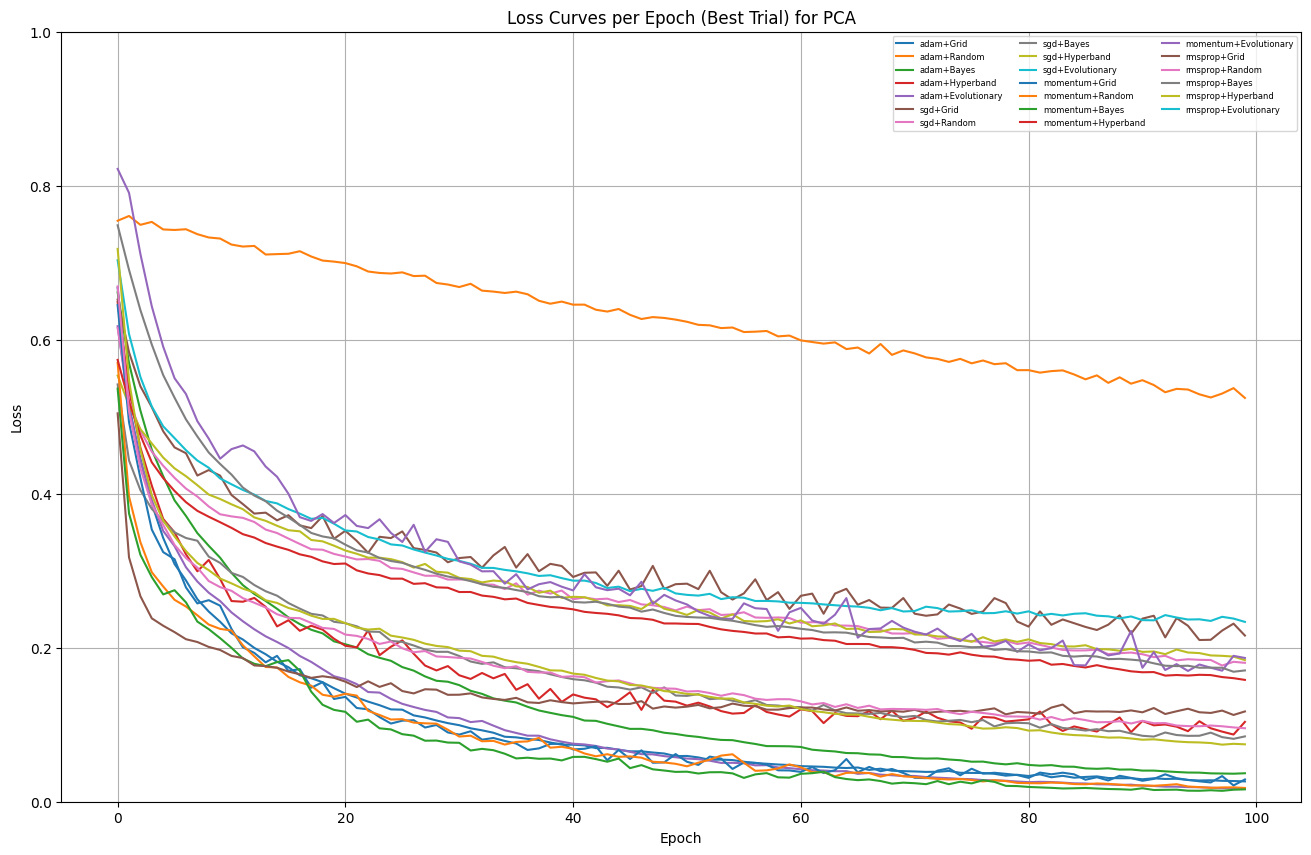

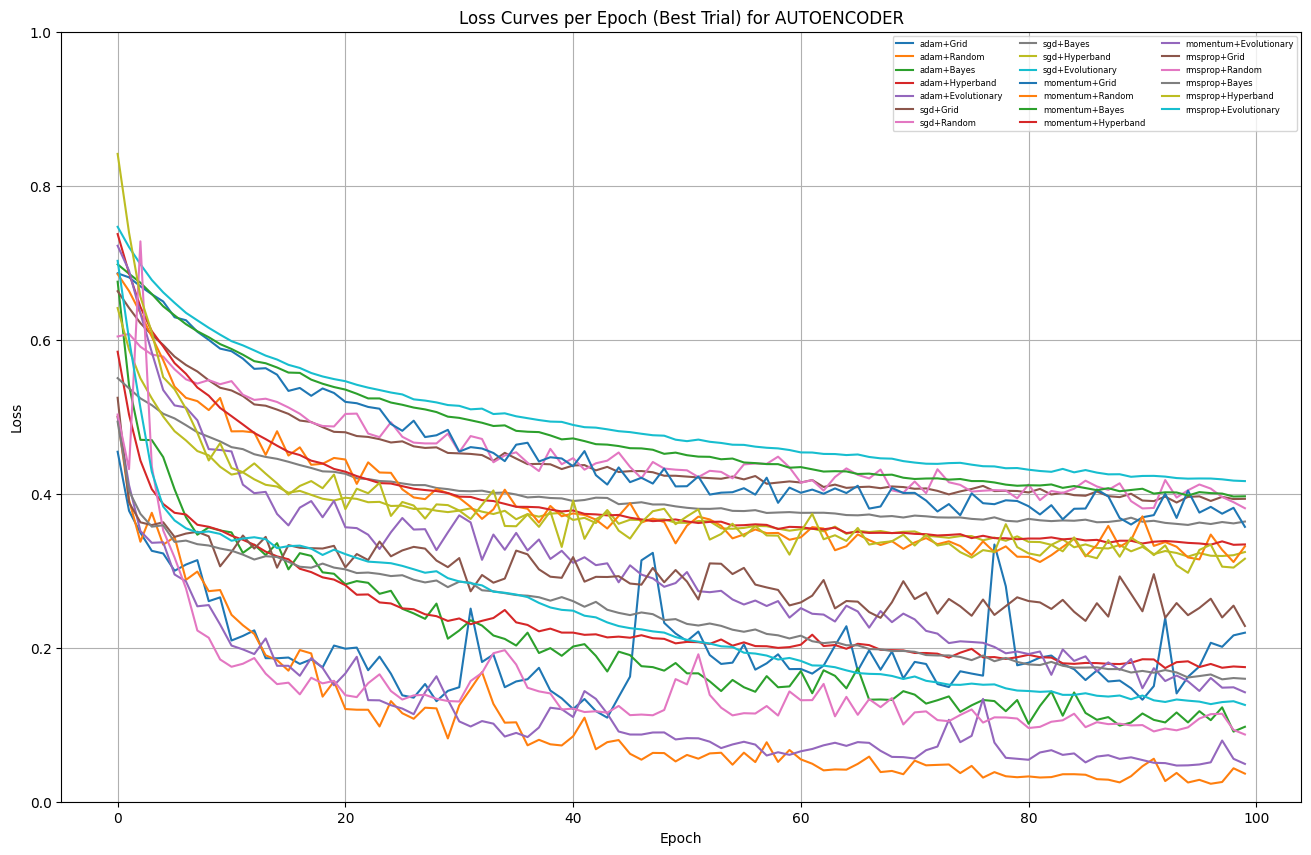

In [57]:
import matplotlib.pyplot as plt


features = ["raw", "kmeans", "pca", "autoencoder"]
optimizers = ["adam", "sgd", "momentum", "rmsprop"]
hp_algos = ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]

for feat in features:
    plt.figure(figsize=(16,10))
    for opt in optimizers:
        for algo in hp_algos:
            loss_curve = results[feat][opt][algo + "_loss"]
            label_name = f"{opt}+{algo}"
            plt.plot(loss_curve, label=label_name)

    plt.ylim([0, 1])
    plt.title(f"Loss Curves per Epoch (Best Trial) for {feat.upper()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(fontsize=6, ncol=3)
    plt.grid(True)
    plt.show()


In [58]:
def compact_params(hp_dict):
    # Convert long dict to short string, rounding floats
    if hp_dict is None:
        return ""
    return ", ".join(f"{k}={round(v, 4) if isinstance(v, float) else v}" for k, v in hp_dict.items())

rows = []

for feat_name, feat_dict in results.items():
    for opt_name, opt_dict in feat_dict.items():
        for algo in ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]:
          time = opt_dict.get(f"{algo}_perf", None)
          met = opt_dict.get(f"{algo}_met", None)
          best_hp = opt_dict.get(algo, None)
          if met is not None:
              rows.append({
                  "Feature": feat_name,
                  "Optimizer": opt_name,
                  "HP Algorithm": algo,
                  "Accuracy": round(met.get("acc", 0), 4),
                  "Precision": round(met.get("prec", 0), 4),
                  "Recall": round(met.get("rec", 0), 4),
                  "F1": round(met.get("f1", 0), 4),
                  "AUC": round(met.get("auc", 0), 4),
                  "Training time": round(time, 4),
                  "Best Params": compact_params(best_hp)
                })

table_clean = pd.DataFrame(rows)

# Export to LaTeX
latex_code = table_clean.to_latex(index=False, longtable=True)
print(latex_code)



\begin{longtable}{lllrrrrrrl}
\toprule
Feature & Optimizer & HP Algorithm & Accuracy & Precision & Recall & F1 & AUC & Training time & Best Params \\
\midrule
\endfirsthead
\toprule
Feature & Optimizer & HP Algorithm & Accuracy & Precision & Recall & F1 & AUC & Training time & Best Params \\
\midrule
\endhead
\midrule
\multicolumn{10}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
raw & adam & Grid & 0.948700 & 0.935500 & 1.000000 & 0.966700 & 0.972400 & 0.683300 & lr=0.01, momentum=0.99, hidden_size=32, weight_decay=0.001, batch_size=32 \\
raw & adam & Random & 0.948700 & 0.935500 & 1.000000 & 0.966700 & 0.955200 & 1.532500 & lr=0.0774, momentum=0.8556, hidden_size=16, weight_decay=0.0007, batch_size=16 \\
raw & adam & Bayes & 0.948700 & 0.935500 & 1.000000 & 0.966700 & 0.972400 & 0.465000 & lr=0.0076, momentum=0.7045, hidden_size=32, weight_decay=0.0023, batch_size=64 \\
raw & adam & Hyperband & 0.948700 & 0.935500 & 1.000000 & 0.966700 & 0.979300 & 0.463200